# Multiplexed shRNA screening AP009 analytics

Biao Li

This notebook includes analysis scripts of processing count table of multiplexed shRNA screening experiments on AP009 cell line received from Cellecta, and evaluating 
* whether multi-shRNA system works as expected
* prognostic effect of genotype X, and
* predictive effect of genetype X on response to treatment

Note - bash commands to convert notebook to pdf:

$>$ `jupyter nbconvert --to latex multi_shrna_screening_ap009.ipynb`

$>$ `xelatex multi_shrna_screening_ap009.tex`


## (ToDos)

* 0 - separate D18-B (technical replicate of D18-A) from the analysis
* 1 - polish up ordering of conditions in plots
* 2 - for each target gene, aggregate across multiple shRNAs
  * currently evaluating each shRNA of each target gene separately
* 3 - spot check QC'ing fastq processing to validate Cellecta's count table
  * also inquiring about counts of clonal barcodes
* 4 - check correlation between cell counts and plasmid counts of all shRNAs for each of pre-Tx NoDox samples 

In [3]:
!pip install matplotlib_venn --trusted-host pypi.python.org --trusted-host pypi.org --trusted-host files.pythonhosted.org

## Dependency pkgs

In [4]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib_venn import venn3

# seed of random number generator
rng_seed = 1234

## Experimental design and parameters

Load experimental design xlsx file (from Ian)
* Master list tab of target genes, vector types, and annotations
* Experimental design tab of groups and samples
  
Load sample description xlsx file (from Cellecta)
* Actual Sample ID and description on flowcell, and inferred information of Group, Day_Tx, Replicate, Dox, etc.

Also check out schematic workflow of experimental design (from Zheng)

![multiplexed shRNA screening experiment](schematic_workflow_experimental_design.png)

In [5]:
# #### experimental design xlsx file
# file_path = "~/Documents/Projects/Multi_shRNA_screening_AP009/data/Multiplexed shRNA screen in 2D AP009 - Cellecta.xlsx"

# xls = pd.ExcelFile(file_path)

# ## Gene targets
# gene_targets_df = pd.read_excel(xls, sheet_name="Master list")
# # Filter out "Individual dual shRNA vector" from gene targets
# filtered_gene_targets_df = gene_targets_df[gene_targets_df["Vector type"] != "Individual dual shRNA vector"]
# filtered_gene_targets = filtered_gene_targets_df["Mouse gene symbol"].dropna().unique()

# # ## Define experimental parameters
# # # Num clonal barcodes per gene
# # num_clonal_barcodes = 12000  
# # # Num shRNAs per gene
# # num_shRNAs_per_gene = 10  
# # # N_reps per condition per timepoint
# # num_replicates = 2  

# ## Define experimental conditions and timepoints 
# # available timepoints
# time_points = ["0d", "3d", "6d", "9d"]
# # experimental conditions based on design
# conditions = [
#     "Baseline_NoDox_Vehicle",
#     "Baseline_Dox_PreTx",  # Only at 0d
#     "Prognostic_Dox_Vehicle",
#     "Predictive_Dox_7977_LowDose",  # IC30 early, IC50 later
#     "Predictive_Dox_7977_HighDose"  # IC90
# ]

In [6]:
#### sample description xlsx file
file_path_cellecta = "~/Documents/Projects/Multi_shRNA_screening_AP009/data/sample_description_rectified.xlsx"

df_sd = pd.read_excel(file_path_cellecta, sheet_name='Sheet1')

# Set the first row as column headers and remove it from the data
df_sd.columns = df_sd.iloc[0]
df_sd = df_sd[1:].reset_index(drop=True)

# Rename columns to remove any unintended whitespace
df_sd.columns = df_sd.columns.str.strip()

Utility function of table viewing

In [7]:
## utility function of printing table
def ViewTable(df, top_n_rows = None):
    table = PrettyTable(df.columns.tolist())
    if top_n_rows:
        df_tmp = df.head(top_n_rows)
    else:
        df_tmp = df
    for row in df_tmp.itertuples(index=False, name=None):
        table.add_row(row)
    print(table)

ViewTable(df_sd, 5)

+-----------+--------------------+----------------+------------------------------------------------+-------------------+---------+-------+--------+-----------+-----+------+
| Sample_ID | Sample_Description |    Library     |                     Vector                     |      Flowcell     |    Tx   | Group | Day_Tx | Replicate | Dox | Note |
+-----------+--------------------+----------------+------------------------------------------------+-------------------+---------+-------+--------+-----------+-----+------+
|     D1    |   T13_Dox_0.6nM    | 2.2K-REVMED-ZZ |  pRSIT16cb-U6tet-sh-CMV-tetR-2A-TagRFP-2A-Puro | 25-03-11  102190  |   Low   |   5   |   9    |     2     |  Y  | nan  |
|     D2    |   T13_Dox_0.6nM    | 2.2K-REVMED-ZZ |  pRSIT16cb-U6tet-sh-CMV-tetR-2A-TagRFP-2A-Puro | 25-03-11  102190  |   Low   |   5   |   9    |     1     |  Y  | nan  |
|     D3    |   T13_Dox_3.5nM    | 2.2K-REVMED-ZZ |  pRSIT16cb-U6tet-sh-CMV-tetR-2A-TagRFP-2A-Puro | 25-03-11  102190  |   High  |   4 

## Barcodes (shRNA) count table
Load count table (from Cellecta) and extract fields of sample IDs and target gene

In [8]:
file_path_count_table = "~/Documents/Projects/Multi_shRNA_screening_AP009/data/Count_Table.csv"
df_counts = pd.read_csv(file_path_count_table)

# Extract columns that start with 'D' plus the 'Gene Symbol / Target Name' column
selected_columns = [col for col in df_counts.columns if col.startswith("D")] + ["Gene Symbol / Target Name"]

# Create a new dataframe with selected columns
df_counts = df_counts[selected_columns].copy()

# Rename 'Gene Symbol / Target Name' to 'target_gene'
df_counts = df_counts.rename(columns={"Gene Symbol / Target Name": "Target_Gene"})

# Rename 'Non-Targeting-Mouse' to 'NT' in the target_gene column
df_counts["Target_Gene"] = df_counts["Target_Gene"].replace("Non-Targeting-Mouse", "NT")

# Ensure there are no NaN values in the target_gene column before counting repeats
df_counts["Target_Gene"] = df_counts["Target_Gene"].fillna("Unknown")

# Generate a sequential ID for each occurrence of target_gene
df_counts["target_gene_repeat_ID"] = df_counts.groupby("Target_Gene").cumcount() + 1

# Format as "01", "02", "03", etc.
df_counts["target_gene_repeat_ID"] = df_counts["target_gene_repeat_ID"].astype(int).apply(lambda x: f"{x:02d}")

# Combine with target_gene to create a unique ID
df_counts["shRNA_ID"] = df_counts["Target_Gene"] + "_" + df_counts["target_gene_repeat_ID"]

# Drop the temporary repeat ID column
df_counts = df_counts.drop(columns=["target_gene_repeat_ID"])

# Update the target_gene_ID column accordingly
df_counts["shRNA_ID"] = df_counts["Target_Gene"] + "_" + df_counts["shRNA_ID"].str.split("_").str[-1]

# melt the dataframe to long format 
df_long = df_counts.melt(id_vars=["Target_Gene", "shRNA_ID"], var_name="Sample_ID", value_name="Read_Counts")

In [9]:
display(df_counts)

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D17,D18-A,D18-B,D19,D20,D21,D22,D23,Target_Gene,shRNA_ID
0,1399,2777,1312,2281,2056,1579,1072,3116,2532,3019,...,1683,1411,1717,1682,2105,1482,1257,1965,NT,NT_01
1,1785,3277,1776,3414,3139,2482,1289,3877,3373,3953,...,2239,2000,2510,2559,2959,2321,1782,2763,NT,NT_02
2,569,1270,539,1025,1075,892,484,1728,1201,1301,...,727,726,804,774,1094,768,601,945,NT,NT_03
3,955,1703,912,1607,1714,1235,817,2199,1727,2160,...,1234,1153,1372,1268,1481,1010,855,1385,NT,NT_04
4,1150,2403,1177,2281,1981,1467,1055,2641,2071,2504,...,1462,1415,1599,1556,2025,1541,1126,1868,NT,NT_05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,460,889,548,870,810,571,332,1141,935,1101,...,723,679,758,709,892,658,475,859,Zeb1,Zeb1_06
2183,725,1451,709,1416,1151,1017,483,1693,1601,1726,...,936,782,970,933,1242,931,757,1071,Zeb1,Zeb1_07
2184,547,1133,575,1052,1093,843,477,1365,1246,1497,...,777,771,868,820,1157,698,637,846,Zeb1,Zeb1_08
2185,1354,2584,1371,2570,2230,1773,1047,3223,2530,3248,...,1740,1610,1877,1745,2160,1681,1329,1973,Zeb1,Zeb1_09


In [10]:
display(df_long)

,Target_Gene,shRNA_ID,Sample_ID,Read_Counts
0,NT,NT_01,D1,1399
1,NT,NT_02,D1,1785
2,NT,NT_03,D1,569
3,NT,NT_04,D1,955
4,NT,NT_05,D1,1150
...,...,...,...,...
52483,Zeb1,Zeb1_06,D23,859
52484,Zeb1,Zeb1_07,D23,1071
52485,Zeb1,Zeb1_08,D23,846
52486,Zeb1,Zeb1_09,D23,1973


In [11]:
### total number of barcodes per sample / condition

In [12]:
df_full = df_long.merge(df_sd[["Sample_ID", "Sample_Description", "Day_Tx", "Tx", "Dox", "Replicate"]], 
                        left_on = "Sample_ID", right_on = "Sample_ID", how = "left")
df_full.to_csv("~/Documents/Projects/Multi_shRNA_screening_AP009/data/long_format_joint_count_data.csv", index = False)

In [13]:
display(df_full)
print(df_full["Target_Gene"].value_counts())

,Target_Gene,shRNA_ID,Sample_ID,Read_Counts,Sample_Description,Day_Tx,Tx,Dox,Replicate
0,NT,NT_01,D1,1399,T13_Dox_0.6nM,9,Low,Y,2
1,NT,NT_02,D1,1785,T13_Dox_0.6nM,9,Low,Y,2
2,NT,NT_03,D1,569,T13_Dox_0.6nM,9,Low,Y,2
3,NT,NT_04,D1,955,T13_Dox_0.6nM,9,Low,Y,2
4,NT,NT_05,D1,1150,T13_Dox_0.6nM,9,Low,Y,2
...,...,...,...,...,...,...,...,...,...
52483,Zeb1,Zeb1_06,D23,859,T4_Dox_NoTx,0,None,Y,1
52484,Zeb1,Zeb1_07,D23,1071,T4_Dox_NoTx,0,None,Y,1
52485,Zeb1,Zeb1_08,D23,846,T4_Dox_NoTx,0,None,Y,1
52486,Zeb1,Zeb1_09,D23,1973,T4_Dox_NoTx,0,None,Y,1


NT               4800
Pdgfra            240
Nf1               240
Nf2               240
Nfe2l2            240
                 ... 
Erbb2             240
Erbb3             240
Ern1              240
Zeb1              240
Cdkn2a(Ink4a)     168
Name: Target_Gene, Length: 200, dtype: int64


Plot total read counts per sample

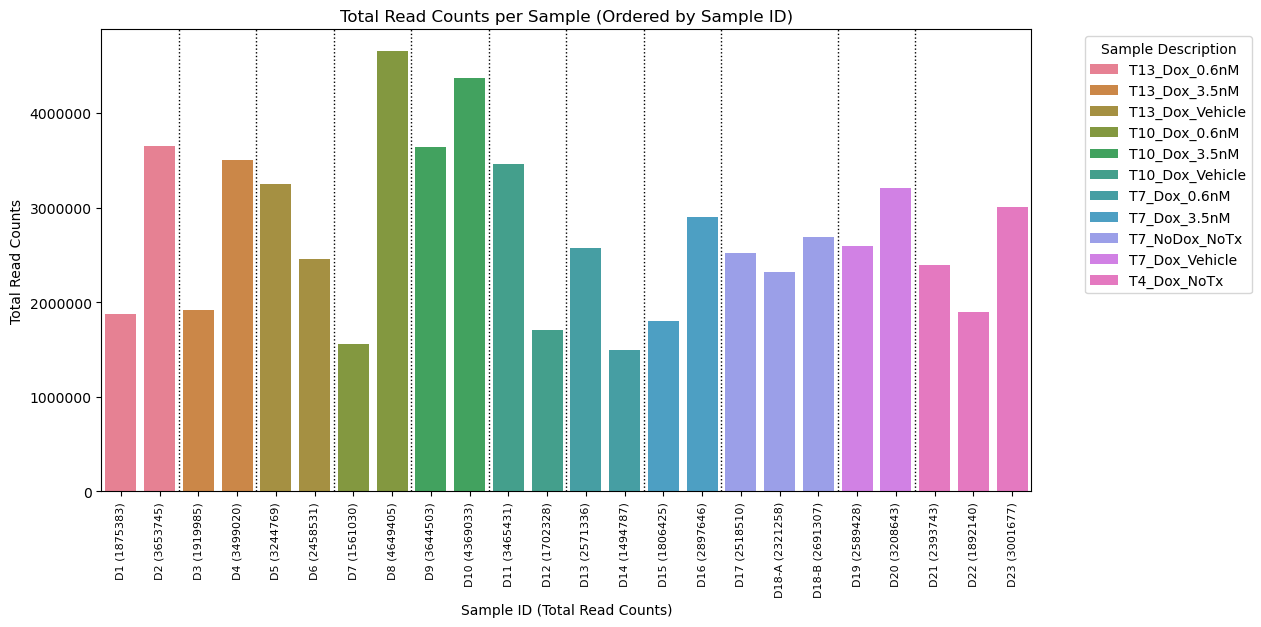

In [14]:
# Aggregate total read counts per sample
df_sample_counts_simple = df_full.groupby(["Sample_ID", "Sample_Description"])["Read_Counts"].sum().reset_index()

# Ensure Sample_ID is sorted numerically rather than lexicographically
df_sample_counts_simple["Sample_ID_Sort"] = df_sample_counts_simple["Sample_ID"].str.extract('(\d+)').astype(int)
df_sample_counts_simple = df_sample_counts_simple.sort_values(by="Sample_ID_Sort").reset_index()

# Modify Sample_ID labels to include total counts in parentheses
df_sample_counts_simple["Sample_ID_Label"] = df_sample_counts_simple.apply(
    lambda row: f"{row['Sample_ID']} ({int(row['Read_Counts'])})", axis=1
)

# Plot the bar chart with modified x-axis labels
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_sample_counts_simple, x="Sample_ID_Label", y="Read_Counts", hue="Sample_Description", dodge=False)

# Identify group transitions for adding vertical dotted lines
prev_desc = None
for index, row in df_sample_counts_simple.iterrows():
    current_desc = row["Sample_Description"]
    if prev_desc is not None and prev_desc != current_desc:
        plt.axvline(x=index - 0.5, color="black", linestyle="dotted", linewidth=1)  # Add vertical separator
    prev_desc = current_desc

# Set y-axis to exact number format
plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation

plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Sample ID (Total Read Counts)")
plt.ylabel("Total Read Counts")
plt.title("Total Read Counts per Sample (Ordered by Sample ID)")
plt.legend(title="Sample Description", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.show()


## Non-targeting shRNAs quantification and selection
Assuming that for each non-targeting shRNA, its reads proportion should be minimally variable among replicates of each experimental condition (as denoted by `Sample_Description` field of `df_full`

In [15]:
# Reload full count table
df_full_path = "~/Documents/Projects/Multi_shRNA_screening_AP009/data/long_format_joint_count_data.csv"
df_full = pd.read_csv(df_full_path)

# Filter for only NT (Non-Targeting) shRNAs
df_nt = df_full[df_full["Target_Gene"] == "NT"]

# Compute total counts per sample
df_total_counts = df_full.groupby("Sample_ID")["Read_Counts"].sum().reset_index()
df_total_counts = df_total_counts.rename(columns={"Read_Counts": "Total_Read_Counts"})

# Merge total counts back to the NT dataset
df_nt = df_nt.merge(df_total_counts, on="Sample_ID", how="left")

# Compute relative proportion for each shRNA within each sample
df_nt["Relative_Proportion"] = df_nt["Read_Counts"] / df_nt["Total_Read_Counts"]

In [16]:
display(df_nt)
print(df_nt["Target_Gene"].value_counts())

,Target_Gene,shRNA_ID,Sample_ID,Read_Counts,Sample_Description,Day_Tx,Tx,Dox,Replicate,Total_Read_Counts,Relative_Proportion
0,NT,NT_01,D1,1399,T13_Dox_0.6nM,9,Low,Y,2,1875383,0.000746
1,NT,NT_02,D1,1785,T13_Dox_0.6nM,9,Low,Y,2,1875383,0.000952
2,NT,NT_03,D1,569,T13_Dox_0.6nM,9,Low,Y,2,1875383,0.000303
3,NT,NT_04,D1,955,T13_Dox_0.6nM,9,Low,Y,2,1875383,0.000509
4,NT,NT_05,D1,1150,T13_Dox_0.6nM,9,Low,Y,2,1875383,0.000613
...,...,...,...,...,...,...,...,...,...,...,...
4795,NT,NT_196,D23,3103,T4_Dox_NoTx,0,None,Y,1,3001677,0.001034
4796,NT,NT_197,D23,1325,T4_Dox_NoTx,0,None,Y,1,3001677,0.000441
4797,NT,NT_198,D23,991,T4_Dox_NoTx,0,None,Y,1,3001677,0.000330
4798,NT,NT_199,D23,1613,T4_Dox_NoTx,0,None,Y,1,3001677,0.000537


NT    4800
Name: Target_Gene, dtype: int64


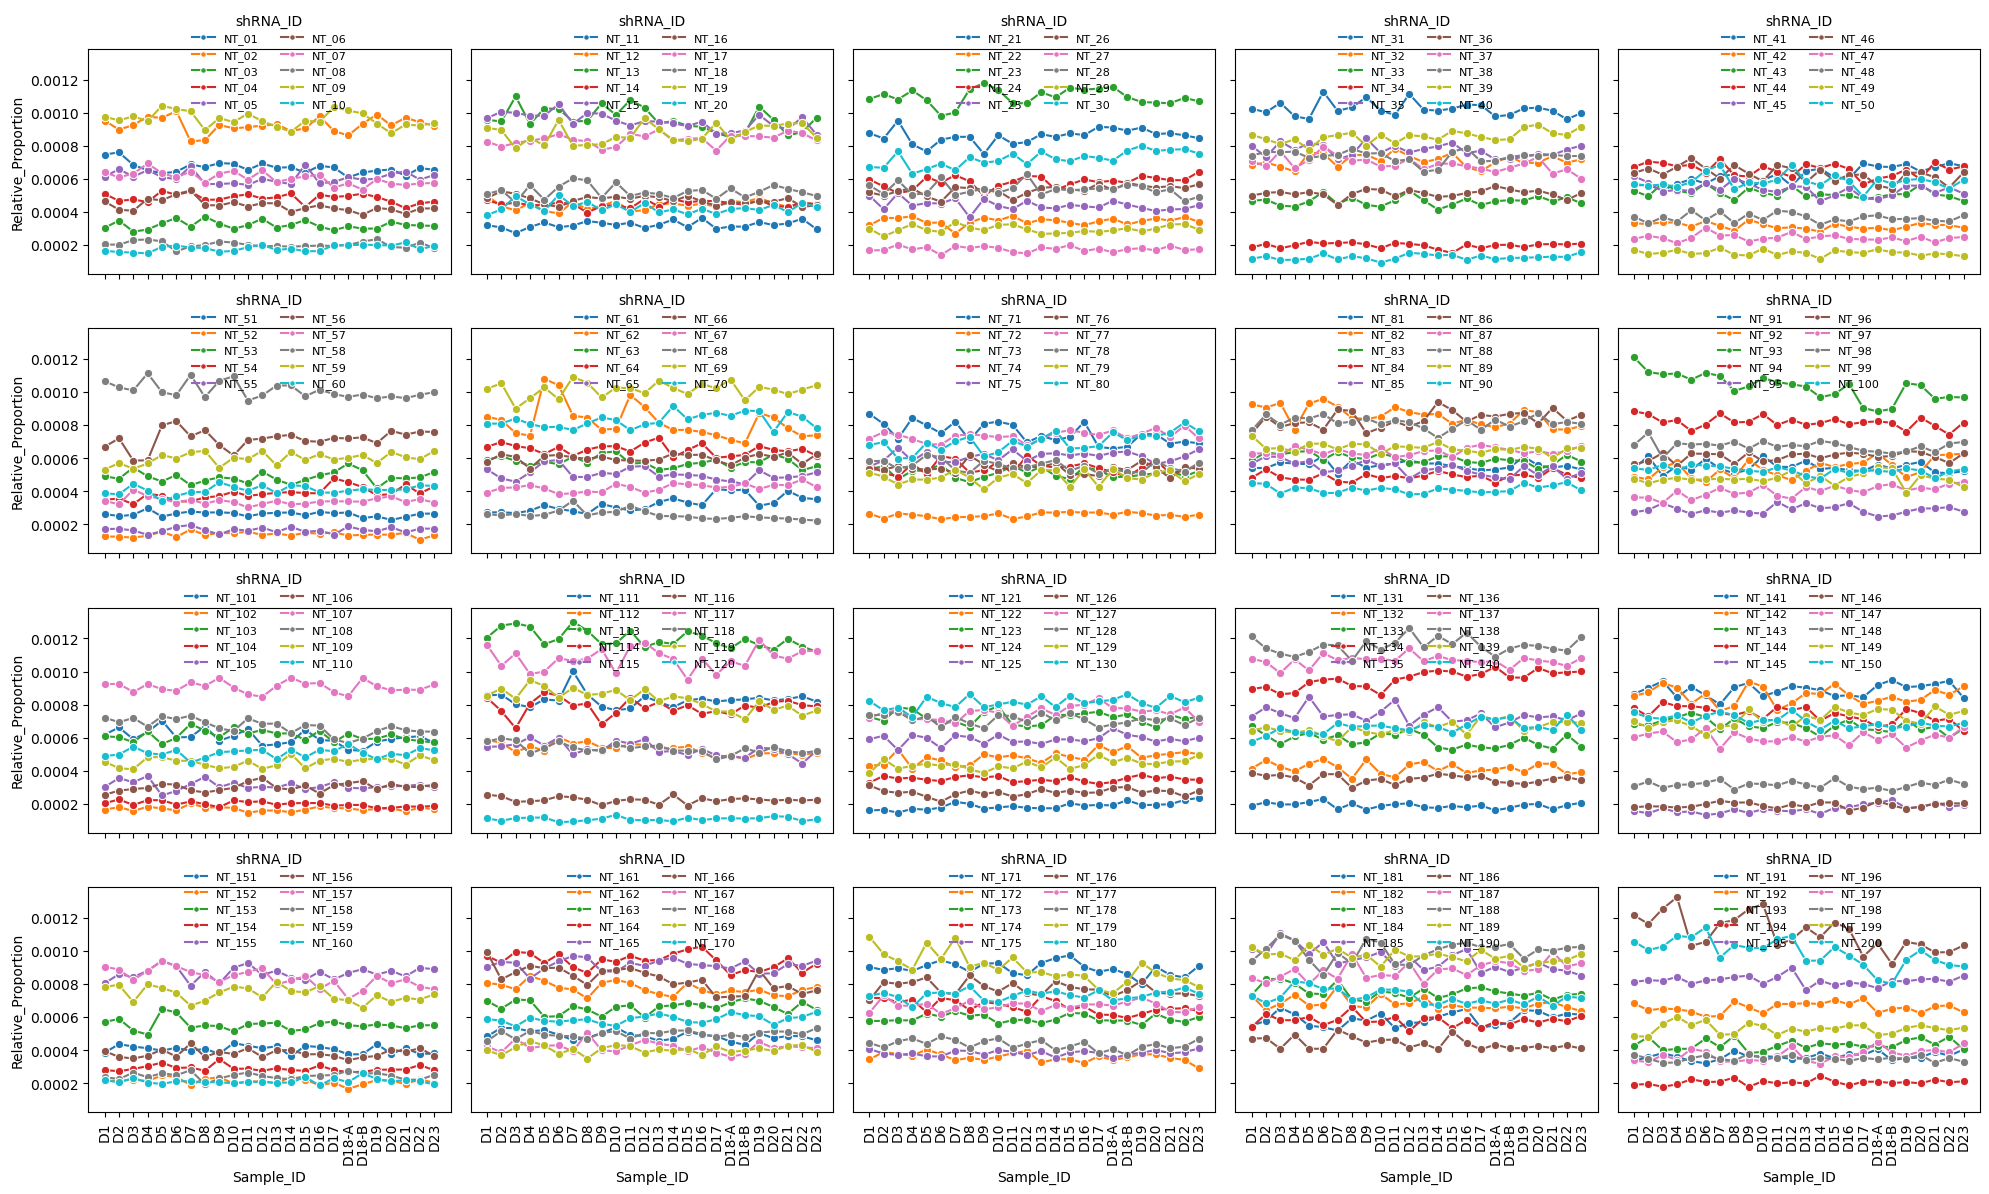

In [17]:
# Get unique shRNA_IDs
unique_shRNAs = df_nt["shRNA_ID"].unique()

# Create a 4x5 subplot grid 
fig, axes = plt.subplots(4, 5, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten 2D array of subplots

# Plot in batches of 10 shRNAs per subplot
batch_size = 10
for i in range(0, len(unique_shRNAs), batch_size):
    shRNA_subset = unique_shRNAs[i:i + batch_size]
    ax = axes[i // batch_size]
    
    sns.lineplot(data=df_nt[df_nt["shRNA_ID"].isin(shRNA_subset)],
                 x="Sample_ID", y="Relative_Proportion", hue="shRNA_ID", marker="o", ax=ax)
    
    ax.tick_params(axis='x', rotation=90)
    
    # Move legend on top of each subplot and shrink marker size to avoid clutter
    legend = ax.legend(title="shRNA_ID", bbox_to_anchor=(0.5, 1.2), loc="upper center", fontsize=8, ncol=2, frameon=False)
    for line in legend.get_lines():
        line.set_markersize(4)  # Reduce marker size

# Adjust layout
plt.tight_layout()
plt.show()


Quantifying CV of reads proportion for each NT shRNA among samples within each experimental condition of `Sample_Description`

In [18]:
# Group by shRNA within each Sample_Description
df_nt_variation = df_nt.groupby(["shRNA_ID", "Sample_Description"])["Relative_Proportion"].agg(
    Mean_Proportion="mean",
    Std_Proportion="std"
).reset_index()

# Compute Coefficient of Variation (CV)
df_nt_variation["CV"] = df_nt_variation["Std_Proportion"] / df_nt_variation["Mean_Proportion"]


In [19]:
display(df_nt_variation)
df_nt_variation.to_csv("~/Documents/Projects/Multi_shRNA_screening_AP009/data/non_targeting_shrna_variation_table.csv", index = False)

,shRNA_ID,Sample_Description,Mean_Proportion,Std_Proportion,CV
0,NT_01,T10_Dox_0.6nM,0.000678,0.000012,0.017231
1,NT_01,T10_Dox_3.5nM,0.000693,0.000003,0.003822
2,NT_01,T10_Dox_Vehicle,0.000673,0.000028,0.041265
3,NT_01,T13_Dox_0.6nM,0.000753,0.000010,0.013204
4,NT_01,T13_Dox_3.5nM,0.000668,0.000022,0.033302
...,...,...,...,...,...
2195,NT_99,T4_Dox_NoTx,0.000457,0.000028,0.061696
2196,NT_99,T7_Dox_0.6nM,0.000470,0.000032,0.068284
2197,NT_99,T7_Dox_3.5nM,0.000461,0.000037,0.080397
2198,NT_99,T7_Dox_Vehicle,0.000444,0.000075,0.167892


In [20]:
display(df_nt_variation[df_nt_variation["Sample_Description"] == "T10_Dox_0.6nM"])

,shRNA_ID,Sample_Description,Mean_Proportion,Std_Proportion,CV
0,NT_01,T10_Dox_0.6nM,0.000678,0.000012,0.017231
11,NT_02,T10_Dox_0.6nM,0.000830,0.000006,0.006931
22,NT_03,T10_Dox_0.6nM,0.000341,0.000044,0.127808
33,NT_04,T10_Dox_0.6nM,0.000498,0.000036,0.071551
44,NT_05,T10_Dox_0.6nM,0.000622,0.000076,0.122570
...,...,...,...,...,...
2145,NT_95,T10_Dox_0.6nM,0.000277,0.000010,0.035703
2156,NT_96,T10_Dox_0.6nM,0.000595,0.000042,0.070011
2167,NT_97,T10_Dox_0.6nM,0.000403,0.000026,0.063755
2178,NT_98,T10_Dox_0.6nM,0.000689,0.000017,0.025127


Boxplot of CV of `df_nt_variation` across NT shRNAs

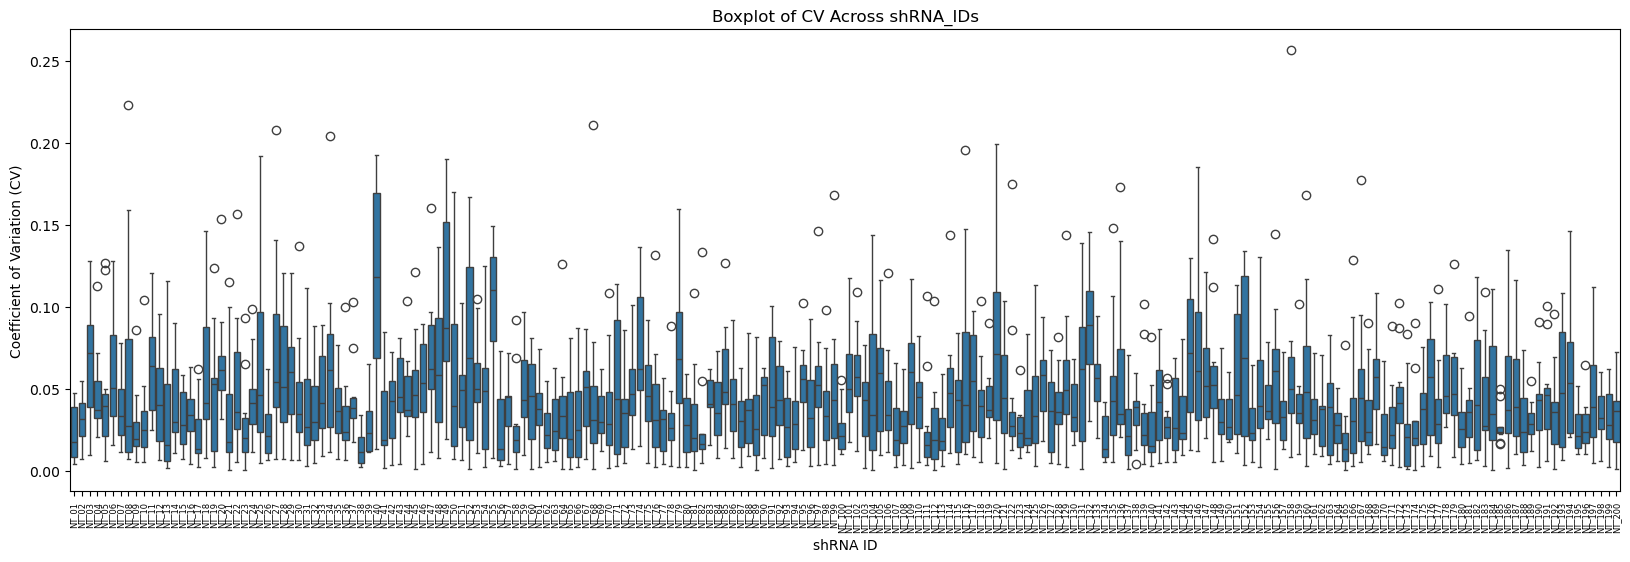

In [21]:
# Extract numeric part of shRNA_ID and sort sequentially from 1 to 200
df_nt_variation["shRNA_Seq"] = df_nt_variation["shRNA_ID"].str.extract(r'(\d+)').astype(int)
df_nt_variation = df_nt_variation.sort_values(by="shRNA_Seq")

# Create a wider boxplot with ordered shRNA_IDs
plt.figure(figsize=(20, 6))
sns.boxplot(data=df_nt_variation, x="shRNA_ID", y="CV")

# Customize the plot
plt.xticks(rotation=90, fontsize=6)  # Smaller font size for x-axis labels
plt.xlabel("shRNA ID")
plt.ylabel("Coefficient of Variation (CV)")
plt.title("Boxplot of CV Across shRNA_IDs")

# Show the plot
plt.show()

Barchart of Median CV of `df_nt_variation` across NT shRNAs with bootstrapped confience internal

In [22]:
# Define function for bootstrapped confidence interval estimation
def bootstrap_median_ci(data, num_resamples=1000, ci=95):
    boot_medians = [np.median(np.random.choice(data, size=len(data), replace=True)) for _ in range(num_resamples)]
    lower_bound = np.percentile(boot_medians, (100 - ci) / 2)
    upper_bound = np.percentile(boot_medians, 100 - (100 - ci) / 2)
    return lower_bound, upper_bound

# Compute median and bootstrapped confidence intervals for each shRNA_ID
df_cv_stats = df_nt_variation.groupby("shRNA_ID")["CV"].agg(
    Median_CV="median"
).reset_index()

# Apply bootstrapping for confidence intervals
df_cv_stats["Lower_CI"], df_cv_stats["Upper_CI"] = zip(*df_nt_variation.groupby("shRNA_ID")["CV"].apply(lambda x: bootstrap_median_ci(x)))

# Calculate error bars (difference between median and lower/upper bounds)
df_cv_stats["Error_Lower"] = df_cv_stats["Median_CV"] - df_cv_stats["Lower_CI"]
df_cv_stats["Error_Upper"] = df_cv_stats["Upper_CI"] - df_cv_stats["Median_CV"]


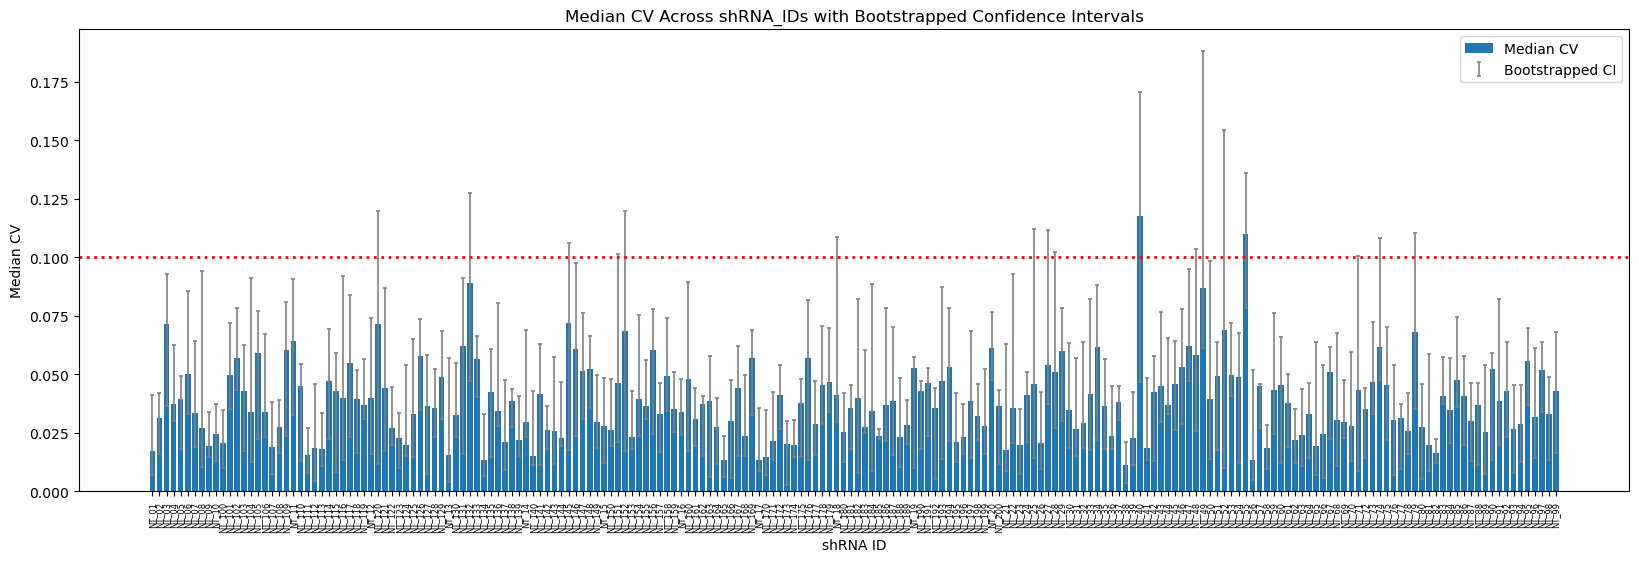

In [23]:
# Create a bar chart with bootstrapped confidence intervals
plt.figure(figsize=(20, 6))

# Plot bars for Median_CV
plt.bar(df_cv_stats["shRNA_ID"], df_cv_stats["Median_CV"], label="Median CV")

# Add error bars with small caps at both ends
plt.errorbar(df_cv_stats["shRNA_ID"], df_cv_stats["Median_CV"], 
             yerr=[df_cv_stats["Error_Lower"], df_cv_stats["Error_Upper"]], 
             fmt='none', ecolor="gray", elinewidth=1.2, capsize=1.5, capthick=1.2, label="Bootstrapped CI")
plt.axhline(y=0.1, color='red', linestyle='dotted', linewidth=2)
# Customize the plot
plt.xticks(rotation=90, fontsize=6)
plt.xlabel("shRNA ID")
plt.ylabel("Median CV")
plt.title("Median CV Across shRNA_IDs with Bootstrapped Confidence Intervals")
plt.legend()

# Show the plot
plt.show()


There are 183 NT shRNA whose bootstrapped confidence internals of median CVs < 0.1

In [24]:
df_selected_nt_boot_median = df_cv_stats[(df_cv_stats["Upper_CI"] < 0.1)]
display(df_selected_nt_boot_median)
df_selected_nt_boot_median.to_csv("~/Documents/Projects/Multi_shRNA_screening_AP009/data/selected_non_targeting_shRNA_table_median_cv_bootstrapped.csv", index = False)

,shRNA_ID,Median_CV,Lower_CI,Upper_CI,Error_Lower,Error_Upper
0,NT_01,0.017231,0.007015,0.041265,0.010216,0.024034
1,NT_02,0.031408,0.016015,0.042011,0.015393,0.010603
2,NT_03,0.071599,0.036633,0.092930,0.034966,0.021331
3,NT_04,0.037188,0.029977,0.062541,0.007211,0.025353
4,NT_05,0.039316,0.017949,0.049489,0.021367,0.010173
...,...,...,...,...,...,...
195,NT_95,0.055613,0.036926,0.069820,0.018688,0.014206
196,NT_96,0.031795,0.014230,0.061475,0.017565,0.029680
197,NT_97,0.051950,0.033848,0.063755,0.018101,0.011805
198,NT_98,0.033246,0.013237,0.048943,0.020009,0.015697


Quantifying overall variability for each NT shRNA by summarizing mean, median, inter-quartile-range, and max CVs, where 
* mean is the average across all conditions
* median is more robust to outliers
* IQR measures spread
* max captures extreme values

In [25]:
df_nt_cv_summary = df_nt_variation.groupby("shRNA_ID")["CV"].agg(
    Mean_CV="mean",
    Median_CV="median",
    IQR_CV=lambda x: x.quantile(0.75) - x.quantile(0.25),  # Interquartile Range
    Max_CV="max"
).reset_index()


In [26]:
display(df_nt_cv_summary)

,shRNA_ID,Mean_CV,Median_CV,IQR_CV,Max_CV
0,NT_01,0.023505,0.017231,0.030772,0.047327
1,NT_02,0.031011,0.031408,0.019975,0.054954
2,NT_03,0.066902,0.071599,0.050576,0.127808
3,NT_04,0.046917,0.037188,0.022093,0.112538
4,NT_05,0.047722,0.039316,0.025738,0.126396
...,...,...,...,...,...
195,NT_95,0.054365,0.055613,0.021983,0.102406
196,NT_96,0.037031,0.031795,0.041091,0.092345
197,NT_97,0.056563,0.051950,0.024747,0.146140
198,NT_98,0.037734,0.033246,0.029870,0.097928


From a total of 200 non-targeting shRNAs Selecting 49 that have 
* low Mean_CV (ensuring overall low variability) 
* low IQR_CV (ensuring tight distribution of variability)
* filtered out cases of extreme outliers (in case Max_CV >= 3 x Median_CV)

In [27]:
mean_cv_threshold = df_nt_cv_summary["Mean_CV"].quantile(0.5)
iqr_cv_threshold = df_nt_cv_summary["IQR_CV"].quantile(0.5)
max_cv_threshold = df_nt_cv_summary["Max_CV"].quantile(0.8)

df_selected_nt = df_nt_cv_summary[
    (df_nt_cv_summary["Mean_CV"] < mean_cv_threshold) &
    (df_nt_cv_summary["IQR_CV"] < iqr_cv_threshold) &
    (df_nt_cv_summary["Max_CV"] < 3 * df_nt_cv_summary["Median_CV"])
]

print(df_selected_nt.shape)

(49, 5)


In [28]:
display(df_nt_variation)

,shRNA_ID,Sample_Description,Mean_Proportion,Std_Proportion,CV,shRNA_Seq
0,NT_01,T10_Dox_0.6nM,0.000678,0.000012,0.017231,1
1,NT_01,T10_Dox_3.5nM,0.000693,0.000003,0.003822,1
2,NT_01,T10_Dox_Vehicle,0.000673,0.000028,0.041265,1
3,NT_01,T13_Dox_0.6nM,0.000753,0.000010,0.013204,1
4,NT_01,T13_Dox_3.5nM,0.000668,0.000022,0.033302,1
...,...,...,...,...,...,...
1322,NT_200,T10_Dox_Vehicle,0.001081,0.000013,0.011939,200
1321,NT_200,T10_Dox_3.5nM,0.001017,0.000002,0.001932,200
1320,NT_200,T10_Dox_0.6nM,0.000998,0.000055,0.054743,200
1324,NT_200,T13_Dox_3.5nM,0.001059,0.000046,0.043319,200


In [29]:
display(df_selected_nt)
df_selected_nt.to_csv("~/Documents/Projects/Multi_shRNA_screening_AP009/data/selected_non_targeting_shRNA_table.csv", index = False)

,shRNA_ID,Mean_CV,Median_CV,IQR_CV,Max_CV
0,NT_01,0.023505,0.017231,0.030772,0.047327
1,NT_02,0.031011,0.031408,0.019975,0.054954
6,NT_07,0.036874,0.033410,0.028563,0.077838
10,NT_100,0.024578,0.020823,0.016112,0.055441
18,NT_108,0.028896,0.027380,0.019566,0.062194
29,NT_118,0.039625,0.039568,0.028879,0.103221
35,NT_123,0.025248,0.022711,0.017982,0.061534
40,NT_128,0.038933,0.035748,0.019580,0.081445
43,NT_130,0.037138,0.032867,0.028425,0.067972
51,NT_138,0.034664,0.038686,0.014556,0.059808


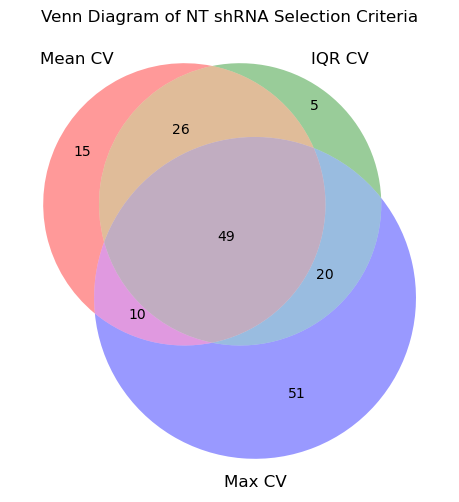

In [30]:
# Define sets for each selection criterion
set_mean_cv = set(df_nt_cv_summary[df_nt_cv_summary["Mean_CV"] < mean_cv_threshold]["shRNA_ID"])
set_iqr_cv = set(df_nt_cv_summary[df_nt_cv_summary["IQR_CV"] < iqr_cv_threshold]["shRNA_ID"])
set_max_cv = set(df_nt_cv_summary[df_nt_cv_summary["Max_CV"] < 3 * df_nt_cv_summary["Median_CV"]]["shRNA_ID"])

# Create Venn diagram
plt.figure(figsize=(6, 6))
venn = venn3([set_mean_cv, set_iqr_cv, set_max_cv], ('Mean CV', 'IQR CV', 'Max CV'))

# Customize colors and labels
plt.title("Venn Diagram of NT shRNA Selection Criteria")
plt.show()

## RCC (relative cell count) 
For each shRNA (`shRNA_ID`) of each target gene (`Target_Gene`) of each condition (`Sample_Description`), RCC is defined and calculated as ratio of total read counts of the shRNA of the target gene divided by total read counts of (selected) non-target genes

In [31]:
## Create df_full_nt_sel by filtering NT shRNAs based on df_selected_nt (or df_selected_nt_boot_median) and keeping all other target genes
df_full_nt_sel = df_full.copy()

# Use df_selected_nt_boot_median to filter on NT shRNAs
df_nt_filtering = df_selected_nt_boot_median
# df_nt_filtering = df_selected_nt

df_full_nt_sel = df_full_nt_sel[
    (df_full_nt_sel["Target_Gene"] != "NT") |  # Keep all non-NT genes
    ((df_full_nt_sel["Target_Gene"] == "NT") & df_full_nt_sel["shRNA_ID"].isin(df_nt_filtering["shRNA_ID"]))  # Keep only selected NT shRNAs
]
print(df_full_nt_sel.shape)

(52080, 9)


In [32]:
display(df_full_nt_sel)

,Target_Gene,shRNA_ID,Sample_ID,Read_Counts,Sample_Description,Day_Tx,Tx,Dox,Replicate
0,NT,NT_01,D1,1399,T13_Dox_0.6nM,9,Low,Y,2
1,NT,NT_02,D1,1785,T13_Dox_0.6nM,9,Low,Y,2
2,NT,NT_03,D1,569,T13_Dox_0.6nM,9,Low,Y,2
3,NT,NT_04,D1,955,T13_Dox_0.6nM,9,Low,Y,2
4,NT,NT_05,D1,1150,T13_Dox_0.6nM,9,Low,Y,2
...,...,...,...,...,...,...,...,...,...
52483,Zeb1,Zeb1_06,D23,859,T4_Dox_NoTx,0,None,Y,1
52484,Zeb1,Zeb1_07,D23,1071,T4_Dox_NoTx,0,None,Y,1
52485,Zeb1,Zeb1_08,D23,846,T4_Dox_NoTx,0,None,Y,1
52486,Zeb1,Zeb1_09,D23,1973,T4_Dox_NoTx,0,None,Y,1


In [33]:
## Compute sum of Read_Counts for each shRNA_ID of each Target_Gene within each Sample_Description
df_summed_counts = df_full_nt_sel.groupby(["Sample_Description", "Target_Gene", "shRNA_ID", "Day_Tx", "Tx", "Dox"])\
    ["Read_Counts"].sum().reset_index()

In [34]:
display(df_summed_counts)

,Sample_Description,Target_Gene,shRNA_ID,Day_Tx,Tx,Dox,Read_Counts
0,T10_Dox_0.6nM,Abcb1,Abcb1_01,6,Low,Y,1952
1,T10_Dox_0.6nM,Abcb1,Abcb1_02,6,Low,Y,2035
2,T10_Dox_0.6nM,Abcb1,Abcb1_03,6,Low,Y,1532
3,T10_Dox_0.6nM,Abcb1,Abcb1_04,6,Low,Y,4146
4,T10_Dox_0.6nM,Abcb1,Abcb1_05,6,Low,Y,4395
...,...,...,...,...,...,...,...
23865,T7_NoDox_NoTx,Zeb1,Zeb1_06,3,None,N,2160
23866,T7_NoDox_NoTx,Zeb1,Zeb1_07,3,None,N,2688
23867,T7_NoDox_NoTx,Zeb1,Zeb1_08,3,None,N,2416
23868,T7_NoDox_NoTx,Zeb1,Zeb1_09,3,None,N,5227


In [35]:
## Calculate RCCs

# Compute the summed Read_Counts across all NT shRNA_IDs for each Sample_Description
df_nt_summed = df_summed_counts[df_summed_counts["Target_Gene"] == "NT"]\
    .groupby("Sample_Description")["Read_Counts"].sum().reset_index()

df_rtn = df_summed_counts.merge(df_nt_summed, on="Sample_Description", suffixes=("", "_NT"))

# df_rtn = df_summed_counts.merge(
#     df_summed_counts[df_summed_counts["Target_Gene"] == "NT"][["Sample_Description", "Read_Counts"]],
#     on="Sample_Description",
#     suffixes=("", "_NT")
# )

# Compute RTN (Read_Counts / Read_Counts of NT)
df_rtn["RTN"] = df_rtn["Read_Counts"] / df_rtn["Read_Counts_NT"]

# Drop the redundant NT read count column
df_rtn = df_rtn.drop(columns=["Read_Counts_NT"])

df_rtn.to_csv("~/Documents/Projects/Multi_shRNA_screening_AP009/data/shrna_target_gene_relative_tumor_number_table.csv", index = False)

In [36]:
display(df_rtn)

,Sample_Description,Target_Gene,shRNA_ID,Day_Tx,Tx,Dox,Read_Counts,RTN
0,T10_Dox_0.6nM,Abcb1,Abcb1_01,6,Low,Y,1952,0.002824
1,T10_Dox_0.6nM,Abcb1,Abcb1_02,6,Low,Y,2035,0.002944
2,T10_Dox_0.6nM,Abcb1,Abcb1_03,6,Low,Y,1532,0.002216
3,T10_Dox_0.6nM,Abcb1,Abcb1_04,6,Low,Y,4146,0.005998
4,T10_Dox_0.6nM,Abcb1,Abcb1_05,6,Low,Y,4395,0.006359
...,...,...,...,...,...,...,...,...
23865,T7_NoDox_NoTx,Zeb1,Zeb1_06,3,None,N,2160,0.002631
23866,T7_NoDox_NoTx,Zeb1,Zeb1_07,3,None,N,2688,0.003274
23867,T7_NoDox_NoTx,Zeb1,Zeb1_08,3,None,N,2416,0.002943
23868,T7_NoDox_NoTx,Zeb1,Zeb1_09,3,None,N,5227,0.006366


In [37]:
print(df_rtn["Sample_Description"].value_counts())

T10_Dox_0.6nM      2170
T10_Dox_3.5nM      2170
T10_Dox_Vehicle    2170
T13_Dox_0.6nM      2170
T13_Dox_3.5nM      2170
T13_Dox_Vehicle    2170
T4_Dox_NoTx        2170
T7_Dox_0.6nM       2170
T7_Dox_3.5nM       2170
T7_Dox_Vehicle     2170
T7_NoDox_NoTx      2170
Name: Sample_Description, dtype: int64


In [38]:
# Split shRNA_ID into two parts: the main ID and the repetition number
df_rtn["shRNA_Rep"] = df_rtn["shRNA_ID"].str.split("_").str[1]


## Prognostic effects 
A vs. B <-> Dox (target gene vs NT) vs. NoDox (target gene vs NT)
* ratio of ratios - `T13_Dox_Vehicle` vs. `T7_NoDox_NoTx`

In [39]:
# Define conditions for A and B
# condition_A = "T7_Dox_Vehicle"
condition_A = "T13_Dox_Vehicle"
condition_B = "T7_NoDox_NoTx"

# Include the Target_Gene field in both condition datasets before merging
df_A = df_rtn[df_rtn["Sample_Description"] == condition_A][["shRNA_ID", "Target_Gene", "RTN"]].rename(columns={"RTN": "RTN_A"})
df_B = df_rtn[df_rtn["Sample_Description"] == condition_B][["shRNA_ID", "Target_Gene", "RTN"]].rename(columns={"RTN": "RTN_B"})

# Merge the two datasets on shRNA_ID and Target_Gene
df_prognostic = df_A.merge(df_B, on=["shRNA_ID", "Target_Gene"], how="inner")

# Compute the prognostic effect (A / B)
df_prognostic["Prognostic_Effect"] = df_prognostic["RTN_A"] / df_prognostic["RTN_B"]


In [40]:
display(df_prognostic)

,shRNA_ID,Target_Gene,RTN_A,RTN_B,Prognostic_Effect
0,Abcb1_01,Abcb1,0.002883,0.003196,0.901969
1,Abcb1_02,Abcb1,0.002869,0.003036,0.944746
2,Abcb1_03,Abcb1,0.002546,0.002592,0.982345
3,Abcb1_04,Abcb1,0.006731,0.005934,1.134384
4,Abcb1_05,Abcb1,0.007275,0.005840,1.245715
...,...,...,...,...,...
2165,Zeb1_06,Zeb1,0.002152,0.002631,0.817944
2166,Zeb1_07,Zeb1,0.003378,0.003274,1.031843
2167,Zeb1_08,Zeb1,0.003017,0.002943,1.025161
2168,Zeb1_09,Zeb1,0.006237,0.006366,0.979753


In [41]:
# Define control gene lists
loss_of_representation_target_genes = ["Rpa1", "Rpa3", "Rps6", "Pcna", "Psmc5", "Rbx1", "Ran", "Snrpd1", "Rpl7", "Kif11"]
neutral_control_target_genes = ["NT", "Trp53"]
gain_of_representation_target_genes = ["Pten"]

# Assign categories for sorting
df_prognostic["Gene_Category"] = "Other"  # Default category
df_prognostic.loc[df_prognostic["Target_Gene"].isin(neutral_control_target_genes), "Gene_Category"] = "Neutral Control"
df_prognostic.loc[df_prognostic["Target_Gene"].isin(loss_of_representation_target_genes), "Gene_Category"] = "Loss of Representation"
df_prognostic.loc[df_prognostic["Target_Gene"].isin(gain_of_representation_target_genes), "Gene_Category"] = "Gain of Representation"

# Sort Target_Gene first by category, then alphabetically within each category
df_prognostic["Sort_Order"] = df_prognostic["Gene_Category"].map({"Neutral Control": 1, 
                                                                  "Loss of Representation": 2, 
                                                                  "Gain of Representation": 3, 
                                                                  "Other": 4})
df_prognostic = df_prognostic.sort_values(by=["Sort_Order", "Target_Gene"])


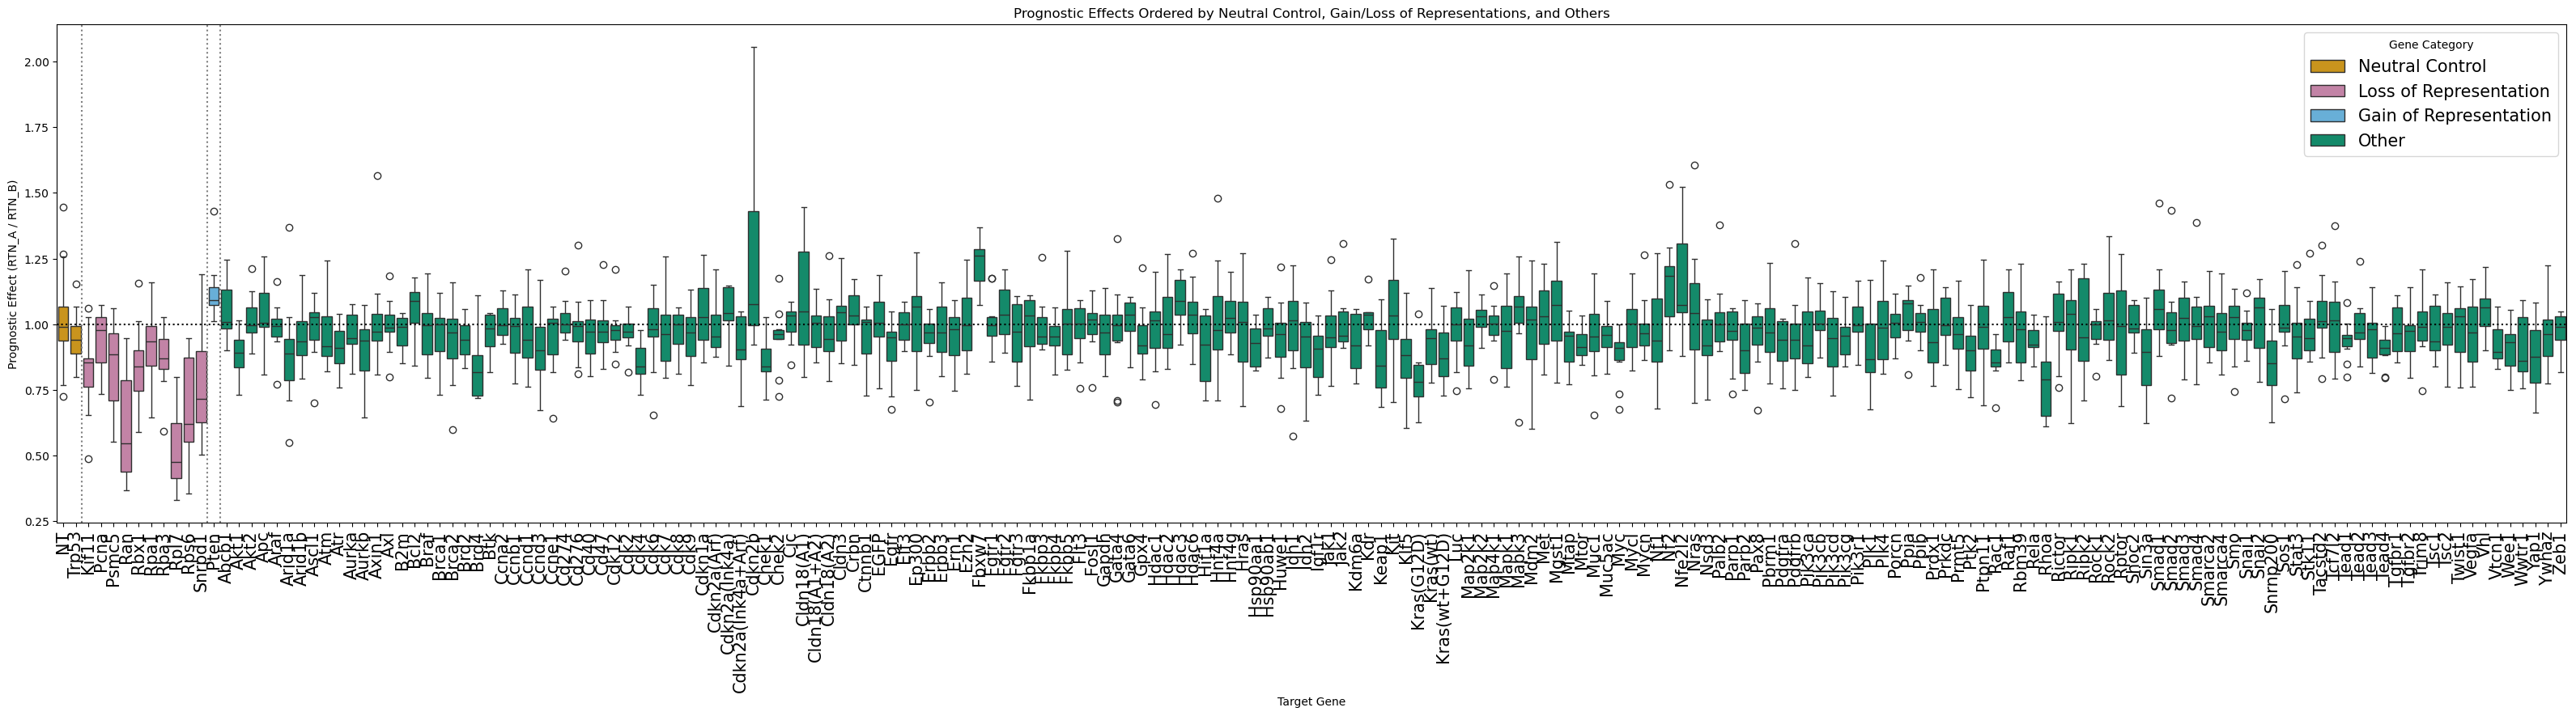

In [42]:
plt.figure(figsize=(40, 8))

# Use a distinct color palette for better differentiation
palette = {"Neutral Control": "#E69F00", 
           "Gain of Representation": "#56B4E9", 
           "Loss of Representation": "#CC79A7", 
           "Other": "#009E73"}

# Create the boxplot
ax = sns.boxplot(data=df_prognostic, x="Target_Gene", y="Prognostic_Effect", hue="Gene_Category", dodge=False, palette=palette)

# Add a horizontal reference line at 1.0
plt.axhline(y=1.0, color="black", linestyle="dotted")

# Compute correct category boundaries
neutral_control_count = df_prognostic[df_prognostic["Gene_Category"] == "Neutral Control"]["Target_Gene"].nunique()
loss_of_representation_count = df_prognostic[df_prognostic["Gene_Category"] == "Loss of Representation"]["Target_Gene"].nunique()
gain_of_representation_count = df_prognostic[df_prognostic["Gene_Category"] == "Gain of Representation"]["Target_Gene"].nunique()

# Add vertical dotted lines at the correct positions
plt.axvline(x=neutral_control_count - 0.5, color="gray", linestyle="dotted")  # End of neutral controls
plt.axvline(x=neutral_control_count + loss_of_representation_count - 0.5, color="gray", linestyle="dotted")  # End of loss of representation
plt.axvline(x=neutral_control_count + loss_of_representation_count + gain_of_representation_count - 0.5, color="gray", linestyle="dotted")

# Customize the plot
plt.xticks(rotation=90, fontsize=10)  # Smaller font size for x-axis labels
plt.xlabel("Target Gene")
plt.ylabel("Prognostic Effect (RTN_A / RTN_B)")
plt.title("Prognostic Effects Ordered by Neutral Control, Gain/Loss of Representations, and Others")
plt.xticks(rotation = 90, fontsize = 15)

# Move legend inside the plot at the top-right corner
plt.legend(title="Gene Category", loc="upper right", fontsize=15, frameon=True)

# Show the plot
plt.show()


In [43]:
display(df_prognostic)

,shRNA_ID,Target_Gene,RTN_A,RTN_B,Prognostic_Effect,Gene_Category,Sort_Order
1147,NT_01,NT,0.005664,0.005860,0.966613,Neutral Control,1
1148,NT_02,NT,0.008759,0.008220,1.065510,Neutral Control,1
1149,NT_03,NT,0.003065,0.002749,1.114952,Neutral Control,1
1150,NT_04,NT,0.004595,0.004578,1.003659,Neutral Control,1
1151,NT_05,NT,0.005373,0.005452,0.985509,Neutral Control,1
...,...,...,...,...,...,...,...
2165,Zeb1_06,Zeb1,0.002152,0.002631,0.817944,Other,4
2166,Zeb1_07,Zeb1,0.003378,0.003274,1.031843,Other,4
2167,Zeb1_08,Zeb1,0.003017,0.002943,1.025161,Other,4
2168,Zeb1_09,Zeb1,0.006237,0.006366,0.979753,Other,4


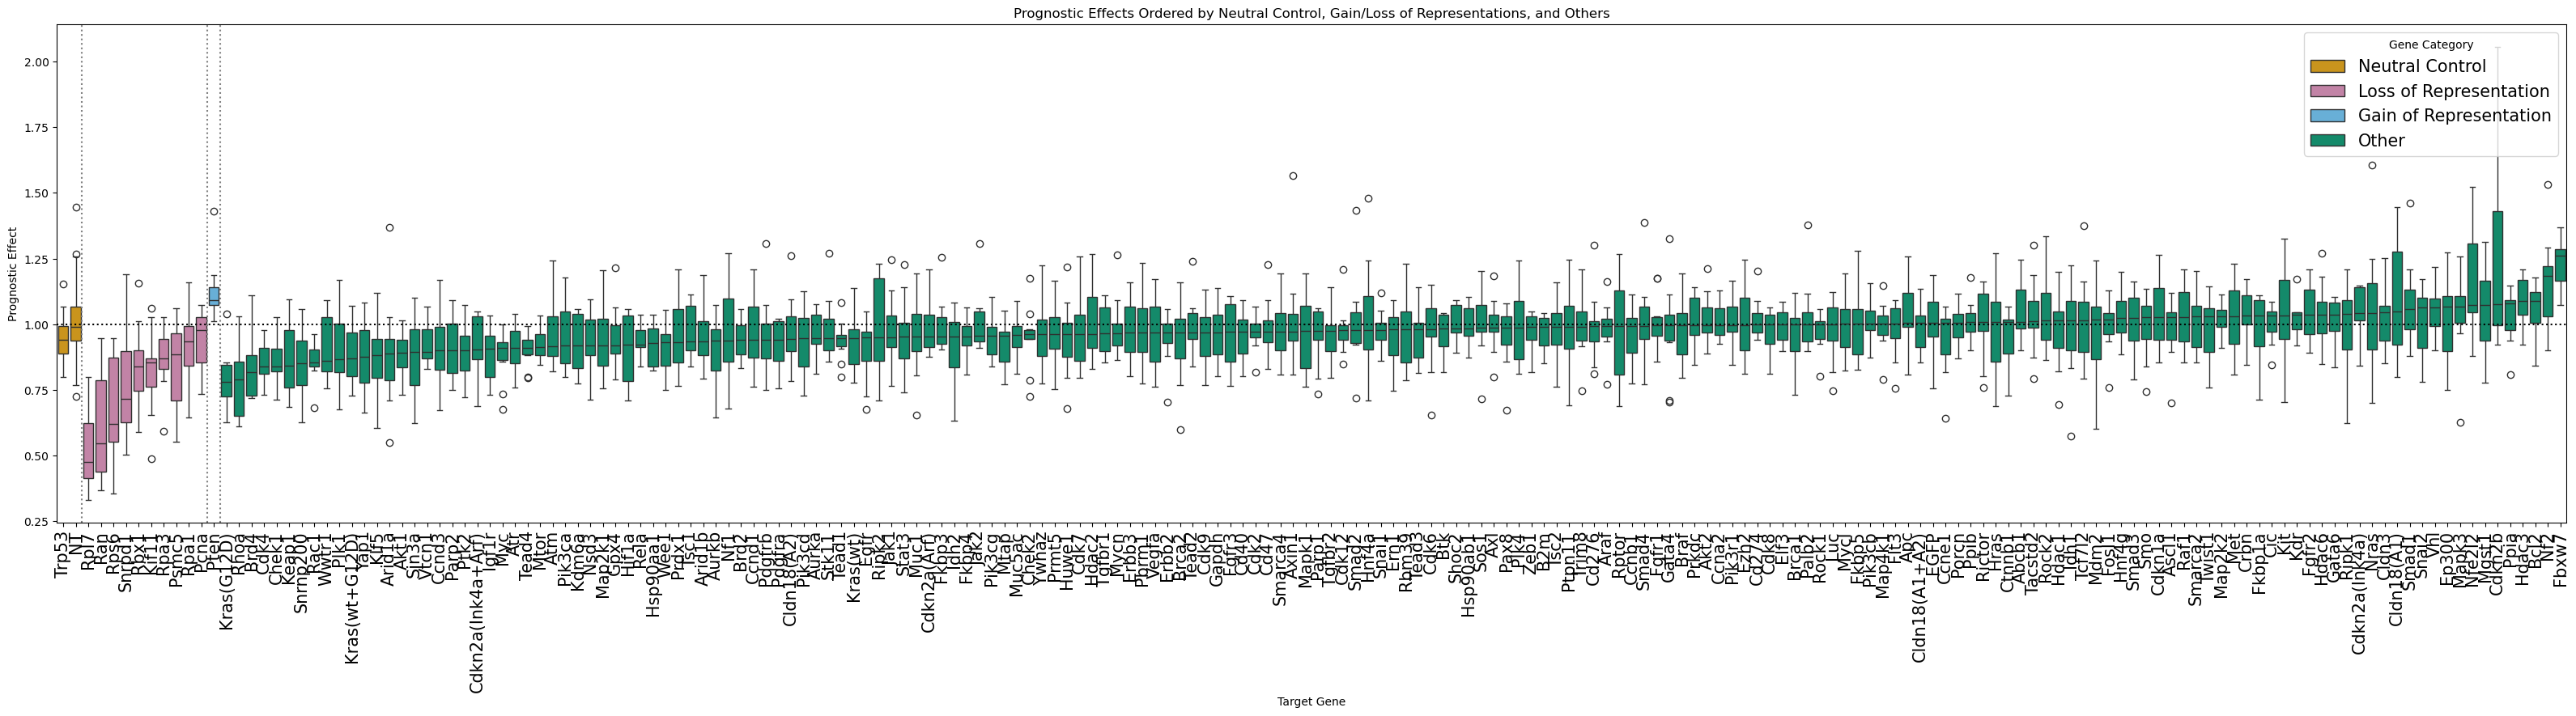

In [44]:
# Compute median Prognostic_Effect for each Target_Gene within each Gene_Category
gene_order = (
    df_prognostic.groupby(["Sort_Order", "Target_Gene"])["Prognostic_Effect"]
    .median()
    .reset_index()
    .sort_values(["Sort_Order", "Prognostic_Effect"], ascending=[True, True])
)

# Update Target_Gene with the new categorical order
df_prognostic["Target_Gene"] = pd.Categorical(
    df_prognostic["Target_Gene"], 
    categories=gene_order["Target_Gene"], 
    ordered=True
)

# Now, re-plot with ordered Target_Gene
plt.figure(figsize=(40, 8))

# Define custom palette
palette = {
    "Neutral Control": "#E69F00", 
    "Gain of Representation": "#56B4E9", 
    "Loss of Representation": "#CC79A7", 
    "Other": "#009E73"
}

# Create the boxplot with the updated Target_Gene order
ax = sns.boxplot(
    data=df_prognostic, 
    x="Target_Gene", 
    y="Prognostic_Effect", 
    hue="Gene_Category", 
    dodge=False, 
    palette=palette
)

# Add a horizontal reference line
plt.axhline(y=1.0, color="black", linestyle="dotted")

# Compute correct category boundaries
neutral_control_count = df_prognostic[df_prognostic["Gene_Category"] == "Neutral Control"]["Target_Gene"].nunique()
loss_of_representation_count = df_prognostic[df_prognostic["Gene_Category"] == "Loss of Representation"]["Target_Gene"].nunique()
gain_of_representation_count = df_prognostic[df_prognostic["Gene_Category"] == "Gain of Representation"]["Target_Gene"].nunique()

# Add vertical dotted lines to separate categories
plt.axvline(x=neutral_control_count - 0.5, color="gray", linestyle="dotted")  
plt.axvline(x=neutral_control_count + loss_of_representation_count - 0.5, color="gray", linestyle="dotted")  
plt.axvline(x=neutral_control_count + loss_of_representation_count + gain_of_representation_count - 0.5, color="gray", linestyle="dotted")

# Customize the plot
plt.xticks(rotation=90, fontsize=15)
plt.xlabel("Target Gene")
plt.ylabel("Prognostic Effect")
plt.title("Prognostic Effects Ordered by Neutral Control, Gain/Loss of Representations, and Others")
plt.legend(title="Gene Category", loc="upper right", fontsize=15, frameon=True)

# Show the plot
plt.show()


## Genotype-specific drug (predictive) effects 
A vs. B <-> Treated (target gene vs NT) vs. Vehicle (target gene vs NT)
* ratio of ratios
* two dosages - 0.6nM and 3.5nM
* three time point - T7, T10, and T13

In [45]:
print(df_rtn["Sample_Description"].value_counts())

T10_Dox_0.6nM      2170
T10_Dox_3.5nM      2170
T10_Dox_Vehicle    2170
T13_Dox_0.6nM      2170
T13_Dox_3.5nM      2170
T13_Dox_Vehicle    2170
T4_Dox_NoTx        2170
T7_Dox_0.6nM       2170
T7_Dox_3.5nM       2170
T7_Dox_Vehicle     2170
T7_NoDox_NoTx      2170
Name: Sample_Description, dtype: int64


In [46]:
# Define all possible treatment vs vehicle comparisons for predictive effect calculation
timepoints = ["T7", "T10", "T13"]
dosages = ["0.6nM", "3.5nM"]

# Prepare an empty list to store results
predictive_effect_results = []

# Iterate over each combination of timepoint and dosage
for timepoint in timepoints:
    for dosage in dosages:
        # Define condition labels for treated (A) and vehicle (B)
        condition_A = f"{timepoint}_Dox_{dosage}"
        condition_B = f"{timepoint}_Dox_Vehicle"
        
        # Filter data for both conditions
        df_A = df_rtn[df_rtn["Sample_Description"] == condition_A][["shRNA_ID", "Target_Gene", "RTN"]].rename(columns={"RTN": "RTN_A"})
        df_B = df_rtn[df_rtn["Sample_Description"] == condition_B][["shRNA_ID", "Target_Gene", "RTN"]].rename(columns={"RTN": "RTN_B"})
        
        # Merge the two datasets on shRNA_ID and Target_Gene
        df_predictive = df_A.merge(df_B, on=["shRNA_ID", "Target_Gene"], how="inner")
        
        # Compute the predictive effect (RTN_A / RTN_B)
        df_predictive["Predictive_Effect"] = df_predictive["RTN_A"] / df_predictive["RTN_B"]
        
        # Add timepoint and dosage for reference
        df_predictive["Timepoint"] = timepoint
        df_predictive["Dosage"] = dosage
        
        # Append results
        predictive_effect_results.append(df_predictive)

# Concatenate all results into a single dataframe
df_predictive_effect = pd.concat(predictive_effect_results, ignore_index=True)


In [47]:
display(df_predictive_effect)

,shRNA_ID,Target_Gene,RTN_A,RTN_B,Predictive_Effect,Timepoint,Dosage
0,Abcb1_01,Abcb1,0.002996,0.003053,0.981311,T7,0.6nM
1,Abcb1_02,Abcb1,0.003000,0.003185,0.942035,T7,0.6nM
2,Abcb1_03,Abcb1,0.002350,0.002373,0.990442,T7,0.6nM
3,Abcb1_04,Abcb1,0.005870,0.006089,0.964018,T7,0.6nM
4,Abcb1_05,Abcb1,0.006047,0.006547,0.923681,T7,0.6nM
...,...,...,...,...,...,...,...
13015,Zeb1_06,Zeb1,0.002341,0.002152,1.087975,T13,3.5nM
13016,Zeb1_07,Zeb1,0.003508,0.003378,1.038571,T13,3.5nM
13017,Zeb1_08,Zeb1,0.002686,0.003017,0.890469,T13,3.5nM
13018,Zeb1_09,Zeb1,0.006507,0.006237,1.043175,T13,3.5nM


In [48]:
# Assign categories for sorting
df_predictive_effect["Gene_Category"] = "Other"  # Default category
df_predictive_effect.loc[df_predictive_effect["Target_Gene"].isin(neutral_control_target_genes), "Gene_Category"] = "Neutral Control"
df_predictive_effect.loc[df_predictive_effect["Target_Gene"].isin(loss_of_representation_target_genes), "Gene_Category"] = "Loss of Representation"
df_predictive_effect.loc[df_predictive_effect["Target_Gene"].isin(gain_of_representation_target_genes), "Gene_Category"] = "Gain of Representation"


# Sort Target_Gene first by category, then alphabetically within each category
df_predictive_effect["Sort_Order"] = df_predictive_effect["Gene_Category"].map({"Neutral Control": 1, 
                                                                  "Loss of Representation": 2, 
                                                                  "Gain of Representation": 3, 
                                                                  "Other": 4})
df_predictive_effect = df_predictive_effect.sort_values(by=["Sort_Order", "Target_Gene"])

# Get unique timepoint-dosage combinations
timepoint_dosage_combinations = df_predictive_effect[["Timepoint", "Dosage"]].drop_duplicates().sort_values(by=["Timepoint", "Dosage"])

print(timepoint_dosage_combinations)

      Timepoint Dosage
5487        T10  0.6nM
7657        T10  3.5nM
9827        T13  0.6nM
11997       T13  3.5nM
1147         T7  0.6nM
3317         T7  3.5nM


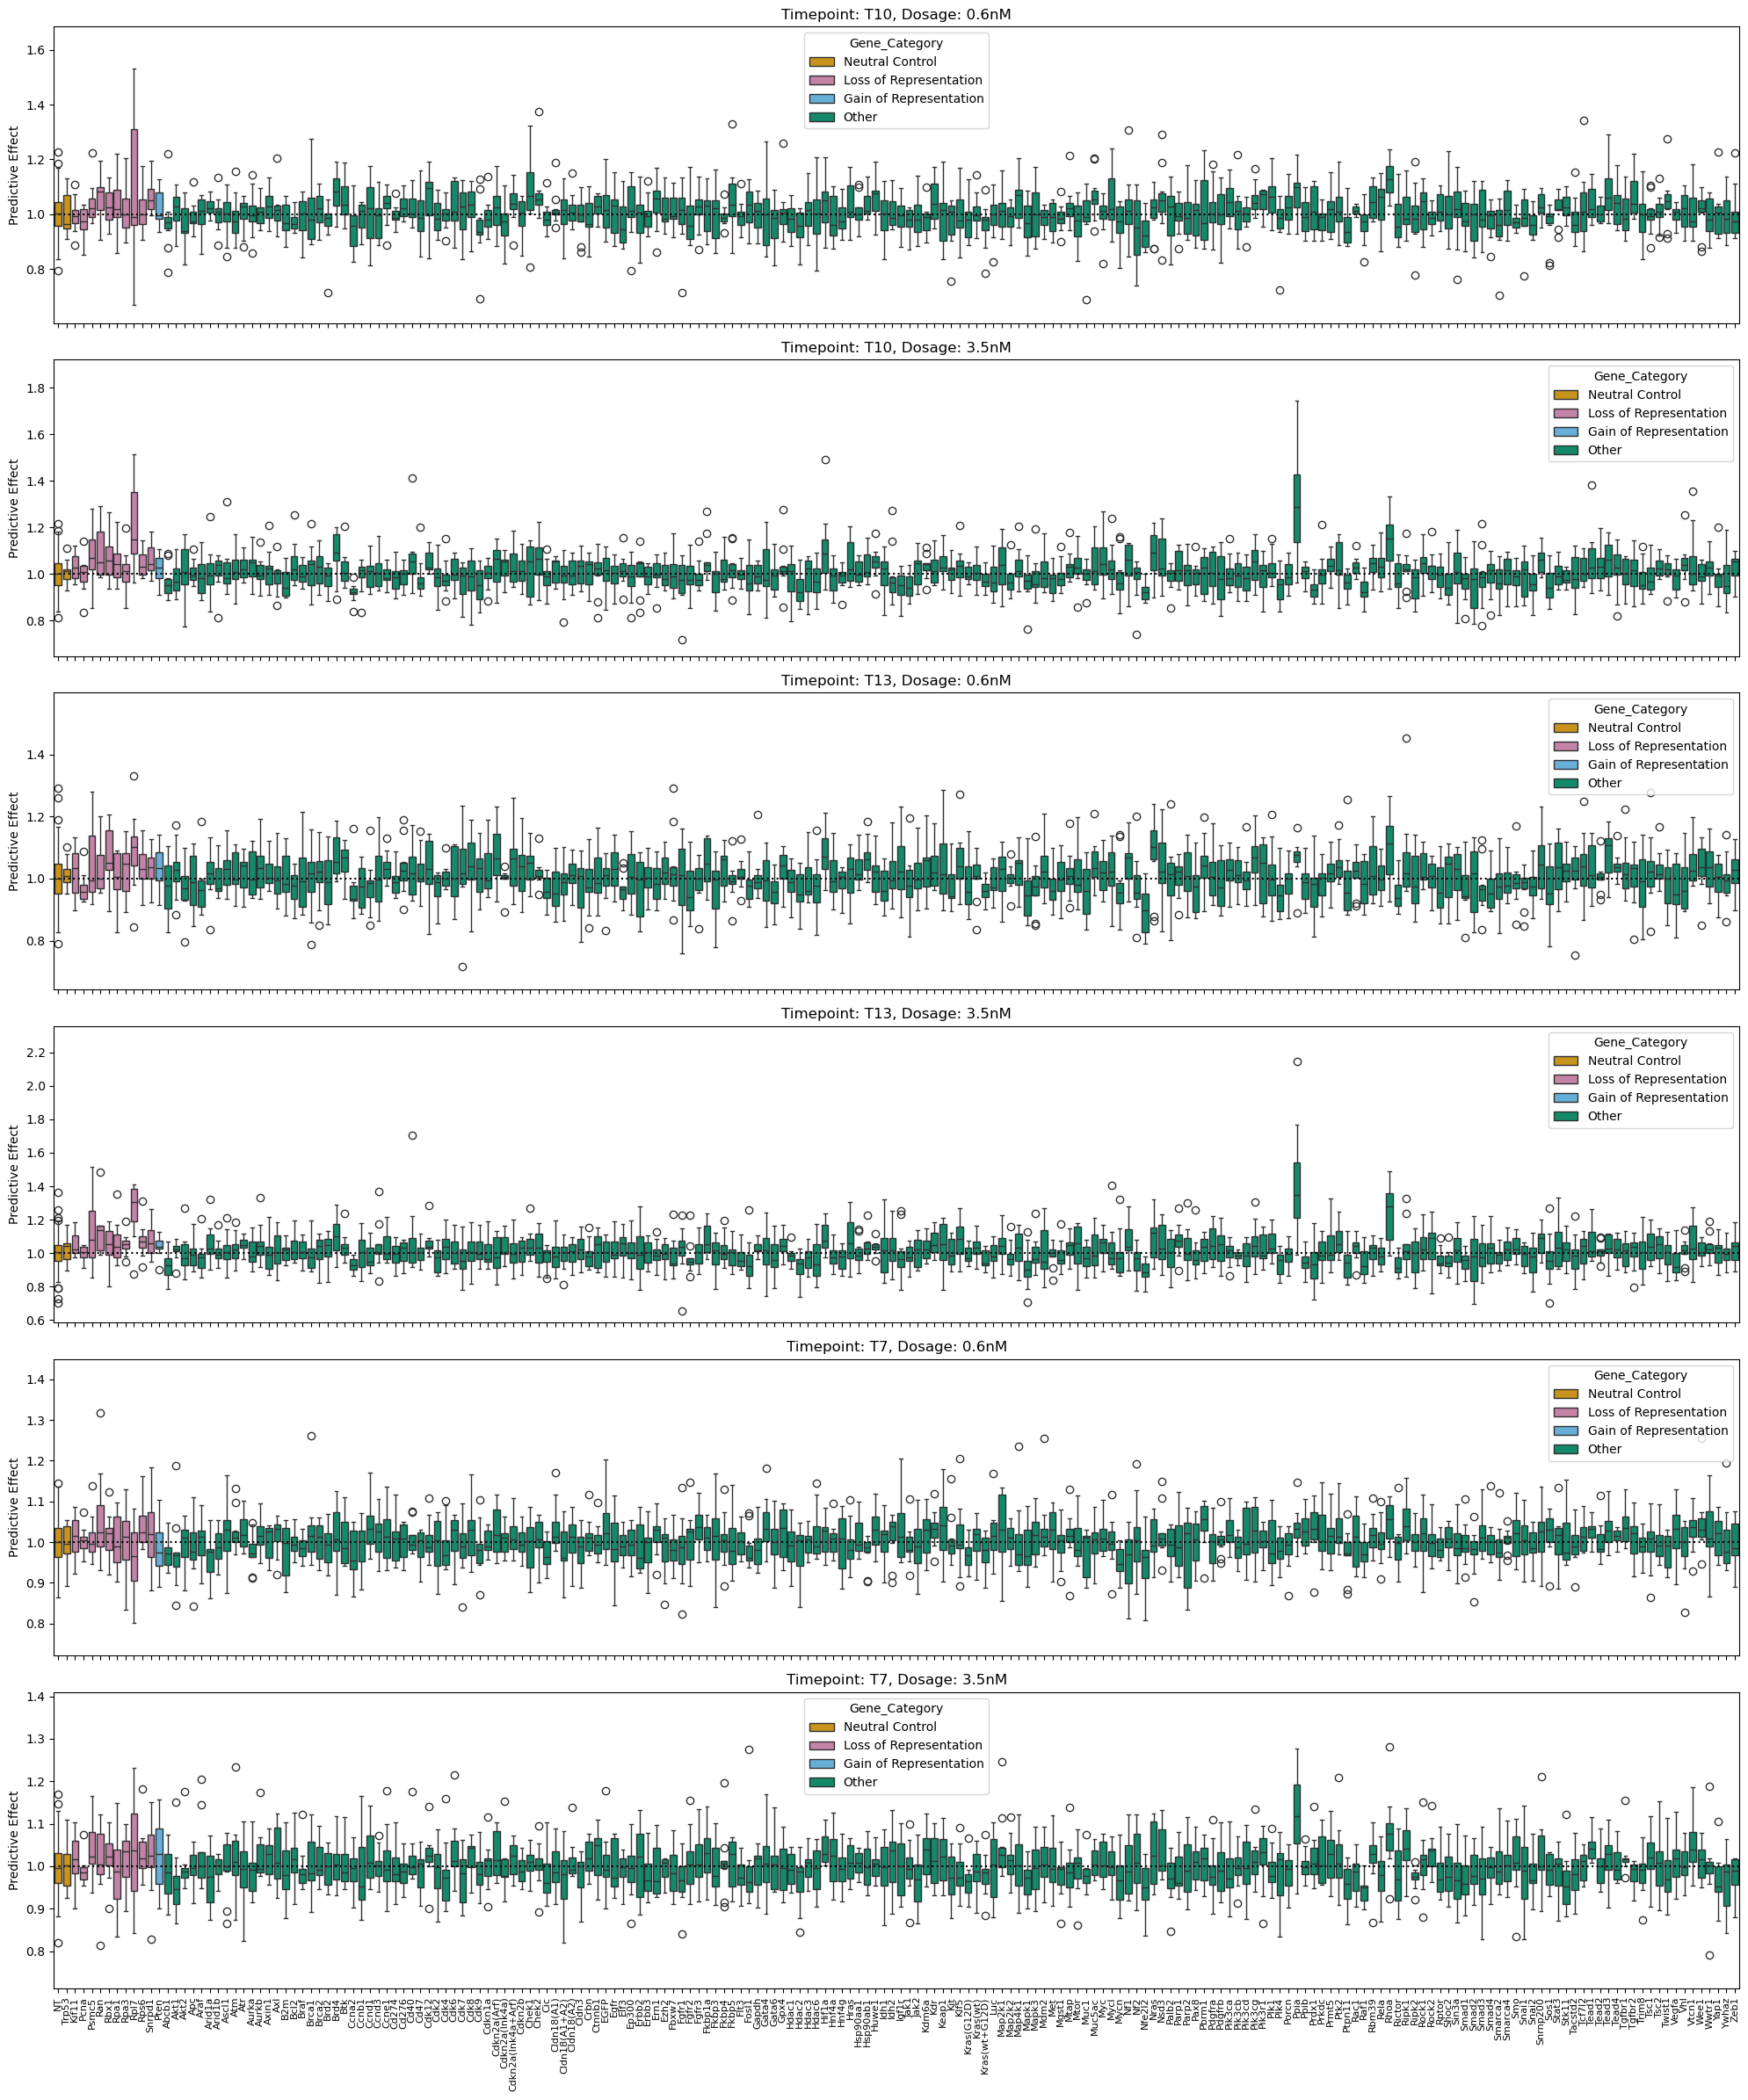

In [49]:
# # Compute correct category boundaries
# neutral_control_count = df_prognostic[df_prognostic["Gene_Category"] == "Neutral Control"]["Target_Gene"].nunique()
# loss_of_representation_count = df_prognostic[df_prognostic["Gene_Category"] == "Loss of Representation"]["Target_Gene"].nunique()
# gain_of_representation_count = df_prognostic[df_prognostic["Gene_Category"] == "Gain of Representation"]["Target_Gene"].nunique()

# # Add vertical dotted lines at the correct positions
# plt.axvline(x=neutral_control_count - 0.5, color="gray", linestyle="dotted")  # End of neutral controls
# plt.axvline(x=neutral_control_count + loss_of_representation_count - 0.5, color="gray", linestyle="dotted")  # End of loss of representation
# plt.axvline(x=neutral_control_count + loss_of_representation_count + gain_of_representation_count - 0.5, color="gray", linestyle="dotted")

# Define grid size (rows = number of combinations, 1 column)
num_rows = len(timepoint_dosage_combinations)
num_cols = 1

# Create the grid plot with individually scaled y-axes for each subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4), sharex=True)

# Ensure axes is always a list for iteration
if num_rows == 1:
    axes = [axes]

# Plot each timepoint-dosage combination in a separate row with individual y-axis scaling
for ax, (timepoint, dosage) in zip(axes, timepoint_dosage_combinations.itertuples(index=False)):
    subset = df_predictive_effect[(df_predictive_effect["Timepoint"] == timepoint) & (df_predictive_effect["Dosage"] == dosage)]
    
    sns.boxplot(data=subset, x="Target_Gene", y="Predictive_Effect", hue="Gene_Category", dodge=False, ax=ax, 
                palette=palette)
    
    ax.axhline(y=1.0, color="black", linestyle="dotted")  # Add reference line at 1.0
    ax.set_title(f"Timepoint: {timepoint}, Dosage: {dosage}", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Predictive Effect")
    ax.tick_params(axis='x', rotation=90, labelsize=8)

    # Adjust y-axis range dynamically based on the subset
    ax.set_ylim(subset["Predictive_Effect"].min() * 0.9, subset["Predictive_Effect"].max() * 1.1)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [50]:
df_predictive_effect.to_csv("~/Documents/Projects/Multi_shRNA_screening_AP009/data/predictive_effect.csv", index = False)